In [37]:
import pymongo as pm #import MongoClient only
from pymongo import MongoClient
import pprint # prettyprinting for json objects
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from datetime import timedelta


client = pm.MongoClient('bigdatadb.polito.it',
                        ssl=True,
                        authSource = 'carsharing',
                        username = 'ictts',
                        password ='Ict4SM22!',
                        tlsAllowInvalidCertificates=True)

db = client['carsharing'] 
Bookings_collection = db['PermanentBookings']

# Collections
bookings_collection = db['PermanentBookings']
parkings_collection = db['PermanentParkings']

#Range for quering
start_date = datetime(2017, 11, 1)  #2017/11/1
end_date = datetime(2018, 1, 31, 23, 59, 59) #2018/01/31 23:59:59

# Our cities
cities = ["Madrid", "Denver", "Austin"]


## Step 1 - Preliminary Data Analysis

### A. Documents in collections 

In [ ]:

print("ActiveBookings: ", db.ActiveBookings.count_documents({}))
print("ActiveParkings: ", db.ActiveParkings.count_documents({}))
print("PermanentBookings: ", db.PermanentBookings.count_documents({}))
print("PermanentParkings: ", db.PermanentParkings.count_documents({}))
print("enjoy_ActiveBookings: ", db.enjoy_ActiveBookings.count_documents({}))
print("enjoy_ActiveParkings: ", db.enjoy_ActiveParkings.count_documents({}))
print("enjoy_PermanentBookings: ", db.enjoy_PermanentBookings.count_documents({}))
print("enjoy_PermanentParkings: ", db.enjoy_PermanentParkings.count_documents({}))

ActiveBookings: 8743
ActiveParkings: 4790
PermanentBookings: 28180508
PermanentParkings: 28312676
enjoy_ActiveBookings: 0
enjoy_ActiveParkings: 0
enjoy_PermanentBookings: 6653472
enjoy_PermanentParkings: 6689979


### B. For each collection : cities with start and end date

In [ ]:
from datetime import datetime, timezone

collections = [
    "ActiveBookings",
    "ActiveParkings",
    "PermanentBookings",
    "PermanentParkings",
    "enjoy_PermanentBookings",
    "enjoy_PermanentParkings"
]

for col in collections:

    print(f"{col}")
    collection = db[col]

    col_cities = set(collection.distinct("city"))
    start_doc = collection.find_one(sort=[("init_date", 1), ("init_time", 1)])
    end_doc = collection.find_one(sort=[("init_date", -1), ("init_time", -1)])

    print("Cities : ", col_cities)

    print(f"Start: {start_doc.get('init_date')} {start_doc.get('init_time')}")
    print(f"End: {end_doc.get('init_date')} {end_doc.get('init_time')}")

    ### Lines to find what is the time difference to UTC+0
    city = start_doc.get('city')
    print(f"City with init_date: {city}")
    unix_time_utc = datetime.fromtimestamp(int(start_doc['init_time']), tz=timezone.utc)

    readable_time = start_doc['init_date']
    readable_time = readable_time.replace(tzinfo=timezone.utc)

    offset = unix_time_utc - readable_time

    print(f"Time difference between init_date and init_time: {offset}")
    print("-----")


ActiveBookings
Cities :  {'Seattle', 'Washington DC', 'Calgary', 'Montreal', 'Stuttgart', 'Roma', 'Frankfurt', 'New York City', 'Firenze', 'Vancouver', 'Madrid', 'Austin', 'Denver', 'Wien', 'Milano', 'Torino', 'Rheinland', 'Hamburg', 'Toronto', 'Munchen', 'Portland', 'Columbus', 'Berlin', 'Amsterdam'}
Start: 2017-12-11 07:45:38 1512999938
End: 2018-01-31 14:13:03 1517404383
City with init_date: Austin
Time difference between init_date and init_time: 6:00:00
-----
ActiveParkings
Cities :  {'Wien', 'Seattle', 'Madrid', 'Washington DC', 'Austin', 'Torino', 'Hamburg', 'Toronto', 'Munchen', 'Firenze', 'Denver', 'Vancouver', 'Columbus'}
Start: 2018-01-23 21:56:00 1516773360
End: 2018-01-31 14:13:03 1517404383
City with init_date: Seattle
Time difference between init_date and init_time: 8:00:00
-----
PermanentBookings
Cities :  {'Seattle', 'Washington DC', 'Twin Cities', 'Stuttgart', 'Montreal', 'Calgary', 'Roma', 'Frankfurt', 'San Diego', 'New York City', 'Firenze', 'Vancouver', 'Madrid', 'A

### C. Numbers of cars

## Step 2 - Analysis


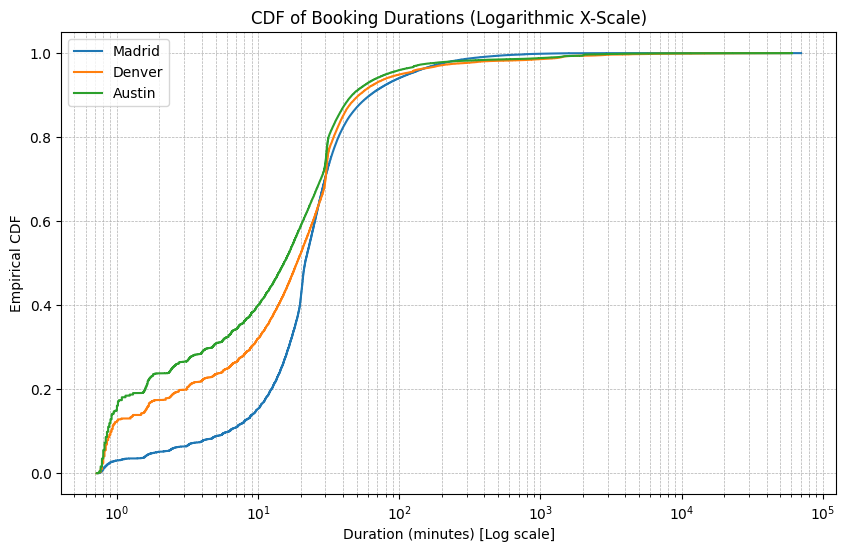

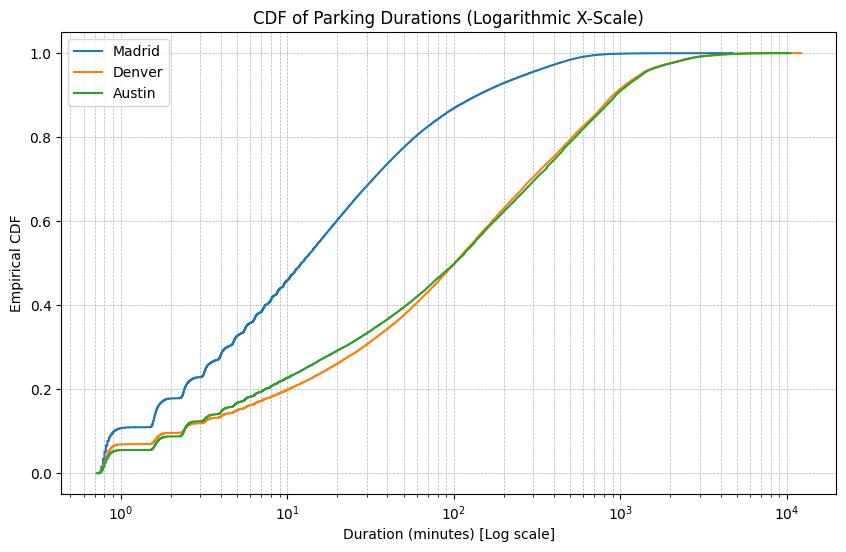

In [46]:
#QUESTION 1
# A and B
# Created to get the durations
def get_durations(collection, city):
    #my query what I need
    query = {
        'city': city,
        'init_date': {'$gte': start_date, '$lte': end_date}, #$gte (greater than or equal) $lte (less than or equal)
        'final_date': {'$exists': True}  
    }
    # Fields to retrieve inicializo lo que voy a rellenenar
    projection = {
        '_id': 0, #esta excluido
        'init_date': 1, #incluidos por el 1
        'final_date': 1
    }
    data = list(collection.find(query, projection)) #en la coleccion guardo una lista con los valores
    # Convert in panda dt frame
    df = pd.DataFrame(data)
    df['init_date'] = pd.to_datetime(df['init_date'])
    df['final_date'] = pd.to_datetime(df['final_date'])
    # Calculate the duration
    df['duration'] = (df['final_date'] - df['init_date']).dt.total_seconds() / 60 #dt.total_seconds() herramienta d pds

    # Filter out any negative or zero durations
    df = df[df['duration'] > 0]
    return df['duration']

#Dicc to save the durations
booking_durations = {}
parking_durations = {}

# Durations of which city
for city in cities:
    booking_durations[city] = get_durations(bookings_collection, city)
    parking_durations[city] = get_durations(parkings_collection, city)
    
#to plot the data
def plot_cdf(durations_dict, title):
    plt.figure(figsize=(10, 6))
    for city, durations in durations_dict.items():
        sorted_data = np.sort(durations)
        yvals = np.arange(1, len(sorted_data)+1) / float(len(sorted_data))
        plt.step(sorted_data, yvals, label=city)
    plt.xscale('log') 
    plt.xlabel('Duration (minutes) [Log scale]')
    plt.ylabel('Empirical CDF')
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5) 
    plt.show()

# Plot CDFs for bookings with logarithmic x-scale
plot_cdf(booking_durations, 'CDF of Booking Durations (Logarithmic X-Scale)')

# Plot CDFs for parkings with logarithmic x-scale
plot_cdf(parking_durations, 'CDF of Parking Durations (Logarithmic X-Scale)')


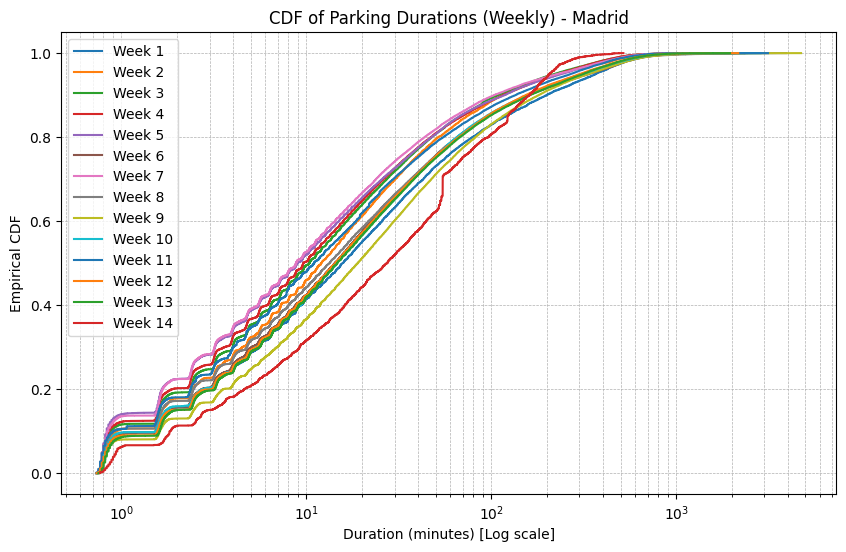

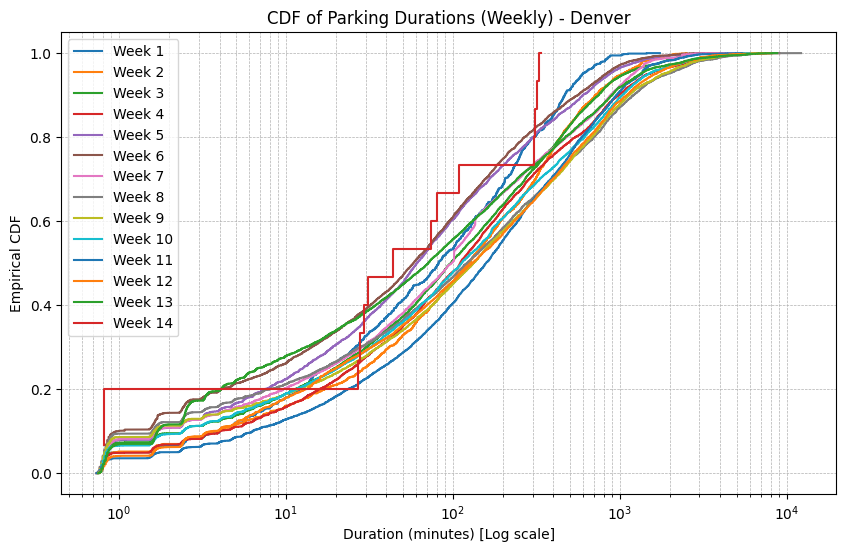

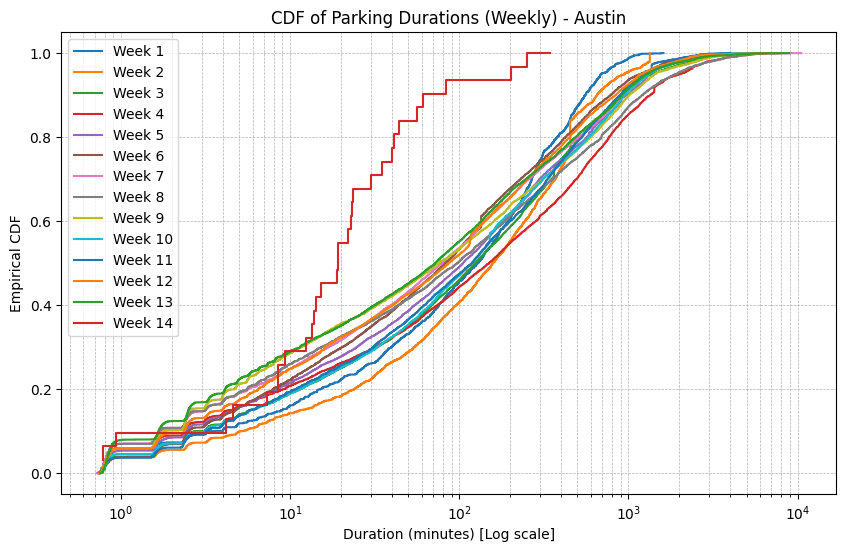

In [47]:
# C
# To take the durations by weekly periods for one city
def get_weekly_durations(collection, city):
    weekly_durations = {}
    start_date = datetime(2017, 11, 1)
    end_date = datetime(2018, 1, 31, 23, 59, 59)
    week = 0

    while start_date < end_date:
        week_end = start_date + timedelta(days=7)
        # Query to filter by city and weekly date range
        query = {
            'city': city,
            'init_date': {'$gte': start_date, '$lt': week_end},
            'final_date': {'$exists': True}
        }
        # Compute duration as before
        data = list(collection.find(query, {'_id': 0, 'init_date': 1, 'final_date': 1}))
        df = pd.DataFrame(data)
        if not df.empty:
            df['init_date'] = pd.to_datetime(df['init_date'])
            df['final_date'] = pd.to_datetime(df['final_date'])
            df['duration'] = (df['final_date'] - df['init_date']).dt.total_seconds() / 60
            df = df[df['duration'] > 0]
            weekly_durations[f"Week {week + 1}"] = df['duration']
        start_date = week_end
        week += 1

    return weekly_durations

# Plot
for city in cities:
    weekly_durations = get_weekly_durations(parkings_collection, city)
    plt.figure(figsize=(10, 6))
    for week, durations in weekly_durations.items():
        sorted_data = np.sort(durations)
        yvals = np.arange(1, len(sorted_data)+1) / float(len(sorted_data))
        plt.step(sorted_data, yvals, label=week)
    plt.xscale('log') 
    plt.xlabel('Duration (minutes) [Log scale]')
    plt.ylabel('Empirical CDF')
    plt.title(f'CDF of Parking Durations (Weekly) - {city}')
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)  
    plt.show()


### Question 2

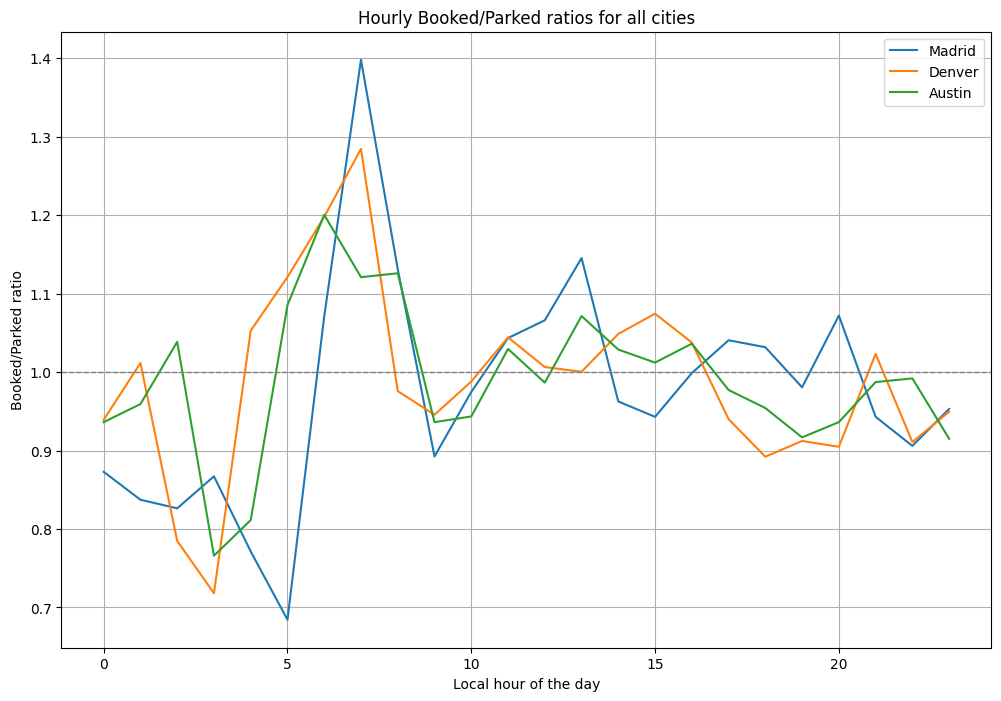

In [40]:

def get_hourly_counts(collection, city):
    query = {'city': city}
    projection = {
        '_id': 0,
        'init_date': 1  # Use init_date directly as it's already in local time
    }
    
    data = list(collection.find(query, projection))
    df = pd.DataFrame(data)

    df['init_date'] = pd.to_datetime(df['init_date']) # Convert init_date to datetime

    df['hour'] = df['init_date'].dt.hour # Extract the hour directly from init_date

    hourly_counts = df['hour'].value_counts().sort_index()  # Count the number of occurrences for each hour

    
    hourly_counts = hourly_counts.reindex(range(24), fill_value=0) # Ensure all hours (0-23) are included, even if no events

    return hourly_counts


plt.figure(figsize=(12, 8))
for city in cities:
    # Get hourly booked and parked counts
    booked_hourly = get_hourly_counts(bookings_collection, city)
    parked_hourly = get_hourly_counts(parkings_collection, city)

    # Calculate the ratio of booked to parked
    ratio_hourly = booked_hourly / parked_hourly
    # Add the city's ratio curve to the plot
    plt.plot(ratio_hourly.index, ratio_hourly, label=f'{city}')

plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Local hour of the day')
plt.ylabel('Booked/Parked ratio')
plt.title('Hourly Booked/Parked ratios for all cities')
plt.legend()
plt.grid()
plt.show()


### Question 4

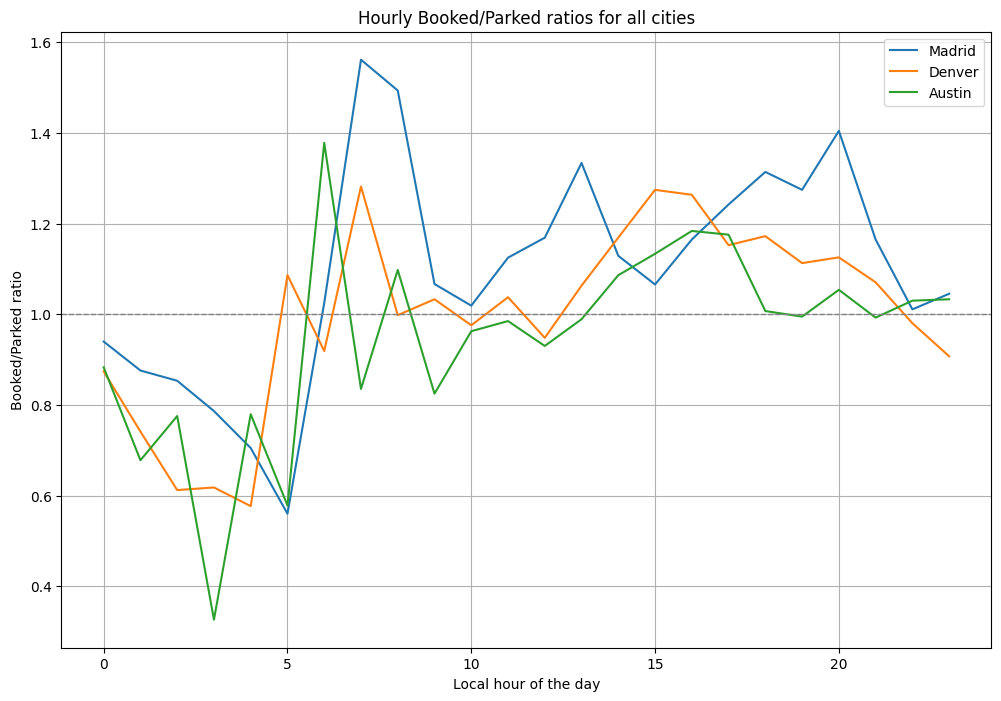

In [51]:
def get_hourly_counts(collection, city):
    pipeline = [
        {
            "$match": {
                "city": city,  # Filter by city
                "init_date": {"$gte": start_date, "$lt": end_date}  # Filter by date range
            }
        },
        {
            "$project": {
                "init_date": 1,
                "final_date": 1,  # Include final_date for Python post-processing
                "initial_position": 1,
                "final_position": 1,
                "duration": {
                    "$divide": [
                        {"$subtract": ["$final_date", "$init_date"]}, 1000 * 60  # Duration in minutes
                    ]
                }
            }
        },
        {
            "$match": {
                "duration": {"$gte": 2, "$lte": 720}  # Filter durations between 2 and 720 minutes
            }
        },
        {
            "$project": {
                "hour": {"$hour": "$init_date"},  # Extract hour from init_date
                "initial_position": 1,
                "final_position": 1
            }
        },
        {
            "$group": {
                "_id": "$hour",
                "count": {"$sum": 1}
            }
        },
        {
            "$sort": {"_id": 1}  # Sort by hour
        }
    ]

    # Run the aggregation pipeline
    results = list(collection.aggregate(pipeline))

    # Convert results to a pandas DataFrame
    df = pd.DataFrame(results)
    df['hour'] = df['_id']
    df = df.drop(columns=['_id'])

    return df


plt.figure(figsize=(12, 8))
for city in cities:
    # Get hourly booked and parked counts
    booked_hourly_df = get_hourly_counts(bookings_collection, city)
    parked_hourly_df = get_hourly_counts(parkings_collection, city)

    # Post-process to filter bookings with same initial and final positions
    if 'initial_position' in booked_hourly_df.columns and 'final_position' in booked_hourly_df.columns:
        booked_hourly_df = booked_hourly_df[booked_hourly_df['initial_position'] != booked_hourly_df['final_position']]

    # Ensure all hours (0-23) are included for booked data
    booked_hourly_df = booked_hourly_df.set_index('hour').reindex(range(24), fill_value=0).reset_index()

    # Ensure all hours (0-23) are included for parked data
    parked_hourly_df = parked_hourly_df.set_index('hour').reindex(range(24), fill_value=0).reset_index()

    # Calculate the ratio of booked to parked
    ratio_hourly = booked_hourly_df['count'] / parked_hourly_df['count'].replace(0, np.nan)  # Avoid division by zero
    # Add the city's ratio curve to the plot
    plt.plot(booked_hourly_df['hour'], ratio_hourly, label=f'{city}')

plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Local hour of the day')
plt.ylabel('Booked/Parked ratio')
plt.title('Hourly Booked/Parked ratios for all cities')
plt.legend()
plt.grid()
plt.show()


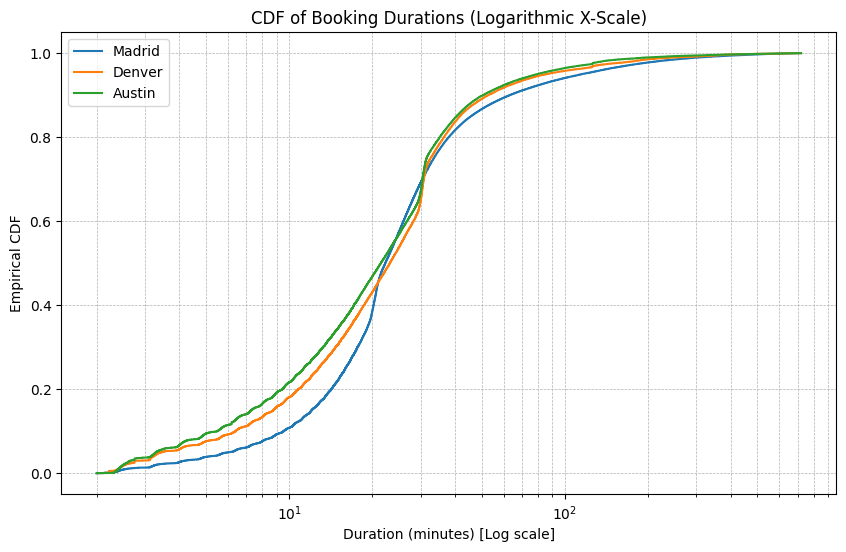

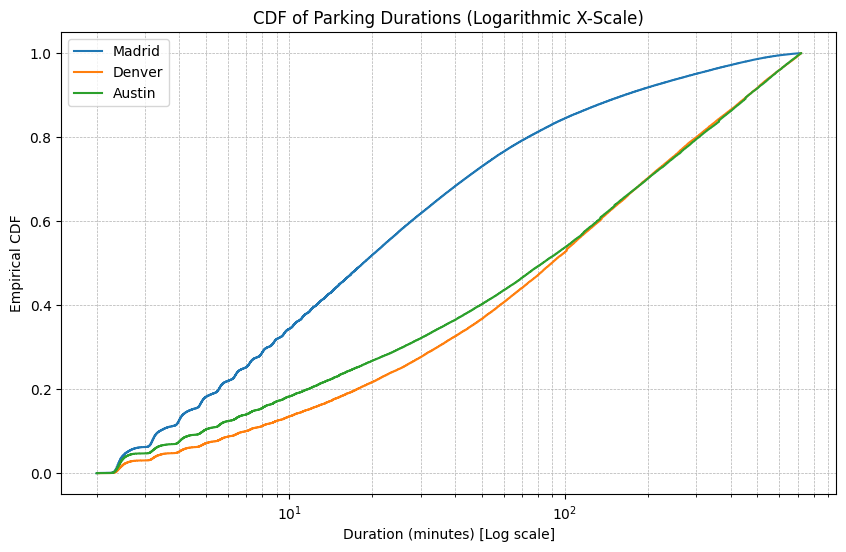

In [74]:
def get_filtered_durations(collection, city):
    pipeline = [
        {
            "$match": {
                "city": city,  # Filter by city
                "init_date": {"$gte": start_date, "$lt": end_date},  # Filter by date range
                "final_date": {"$exists": True}  # Ensure final_date exists
            }
        },
        {
            "$project": {
                "init_date": 1,
                "final_date": 1,
                "initial_position": 1,
                "final_position": 1,
                "duration": {
                    "$divide": [
                        {"$subtract": ["$final_date", "$init_date"]}, 1000 * 60  # Duration in minutes
                    ]
                }
            }
        },
        {
            "$match": {
                "duration": {"$gte": 2, "$lte": 720}  # Filter durations between 2 and 720 minutes
            }
        }
    ]

    # Run the aggregation pipeline
    results = list(collection.aggregate(pipeline))

    # Convert results to a pandas DataFrame
    df = pd.DataFrame(results)
    if not df.empty:
        df['init_date'] = pd.to_datetime(df['init_date'])
        df['final_date'] = pd.to_datetime(df['final_date'])
        # Post-process to filter bookings with distinct initial and final positions
        if 'initial_position' in df.columns and 'final_position' in df.columns:
            df = df[(df['initial_position'] != df['final_position']) | df['initial_position'].isna()]

    return df['duration'] if not df.empty else pd.Series()

# Dictionaries to store the durations
booking_durations = {}
parking_durations = {}

# Get filtered durations for each city
for city in cities:
    booking_durations[city] = get_filtered_durations(bookings_collection, city)
    parking_durations[city] = get_filtered_durations(parkings_collection, city)

# Function to plot the CDF
def plot_cdf(durations_dict, title):
    plt.figure(figsize=(10, 6))
    for city, durations in durations_dict.items():
        if not durations.empty:
            sorted_data = np.sort(durations)
            yvals = np.arange(1, len(sorted_data)+1) / float(len(sorted_data))
            plt.step(sorted_data, yvals, label=city)
    plt.xscale('log') 
    plt.xlabel('Duration (minutes) [Log scale]')
    plt.ylabel('Empirical CDF')
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5) 
    plt.show()

# Plot CDFs for bookings with logarithmic x-scale
plot_cdf(booking_durations, 'CDF of Booking Durations (Logarithmic X-Scale)')

# Plot CDFs for parkings with logarithmic x-scale
plot_cdf(parking_durations, 'CDF of Parking Durations (Logarithmic X-Scale)')


### Question 5

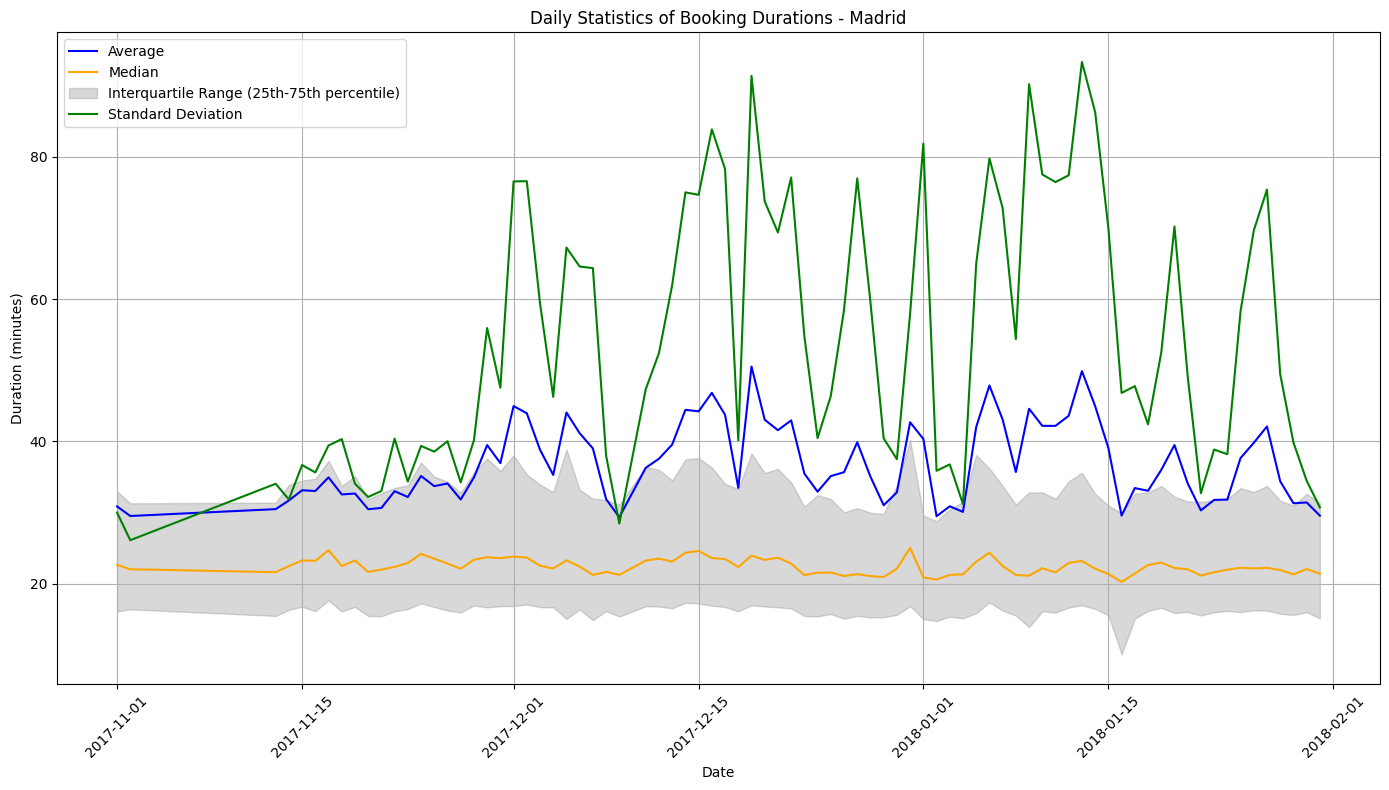

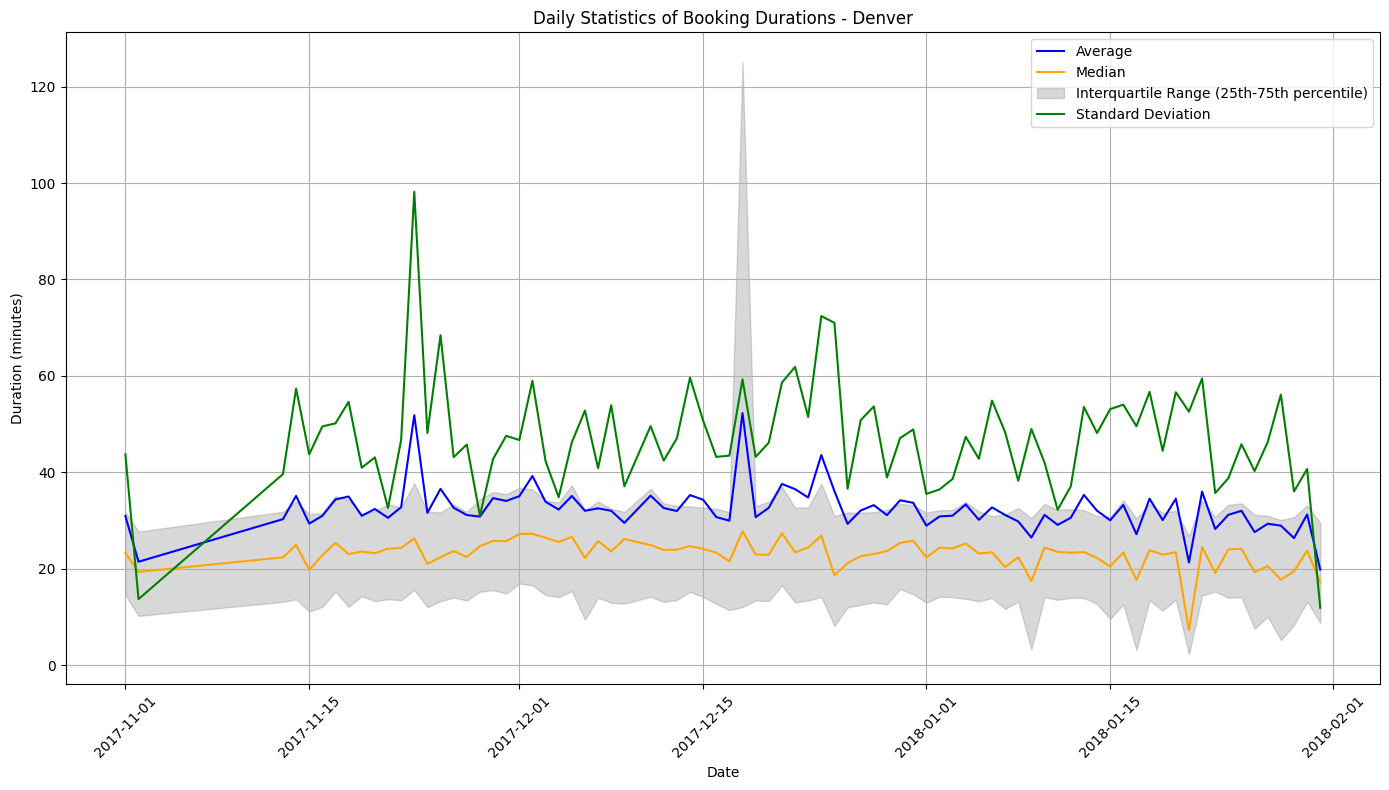

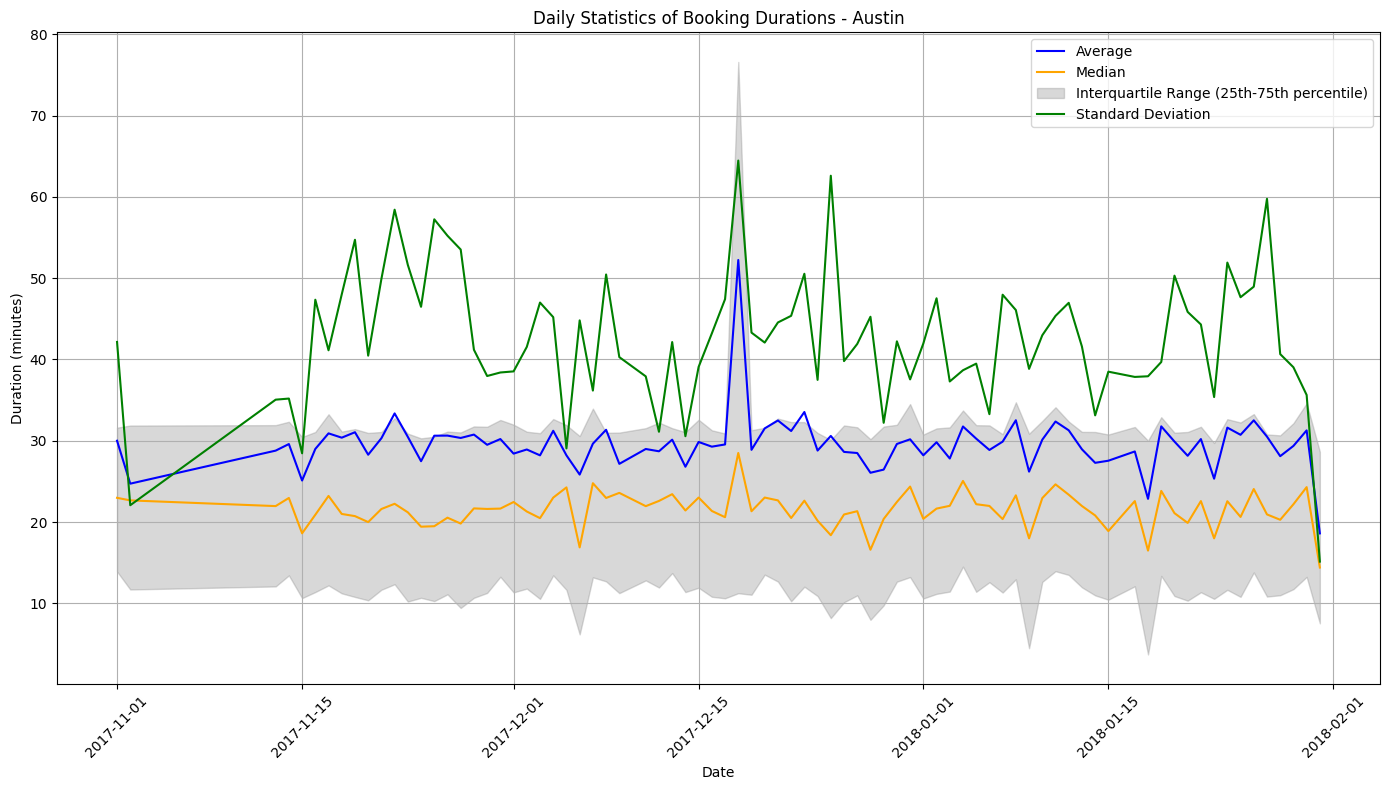

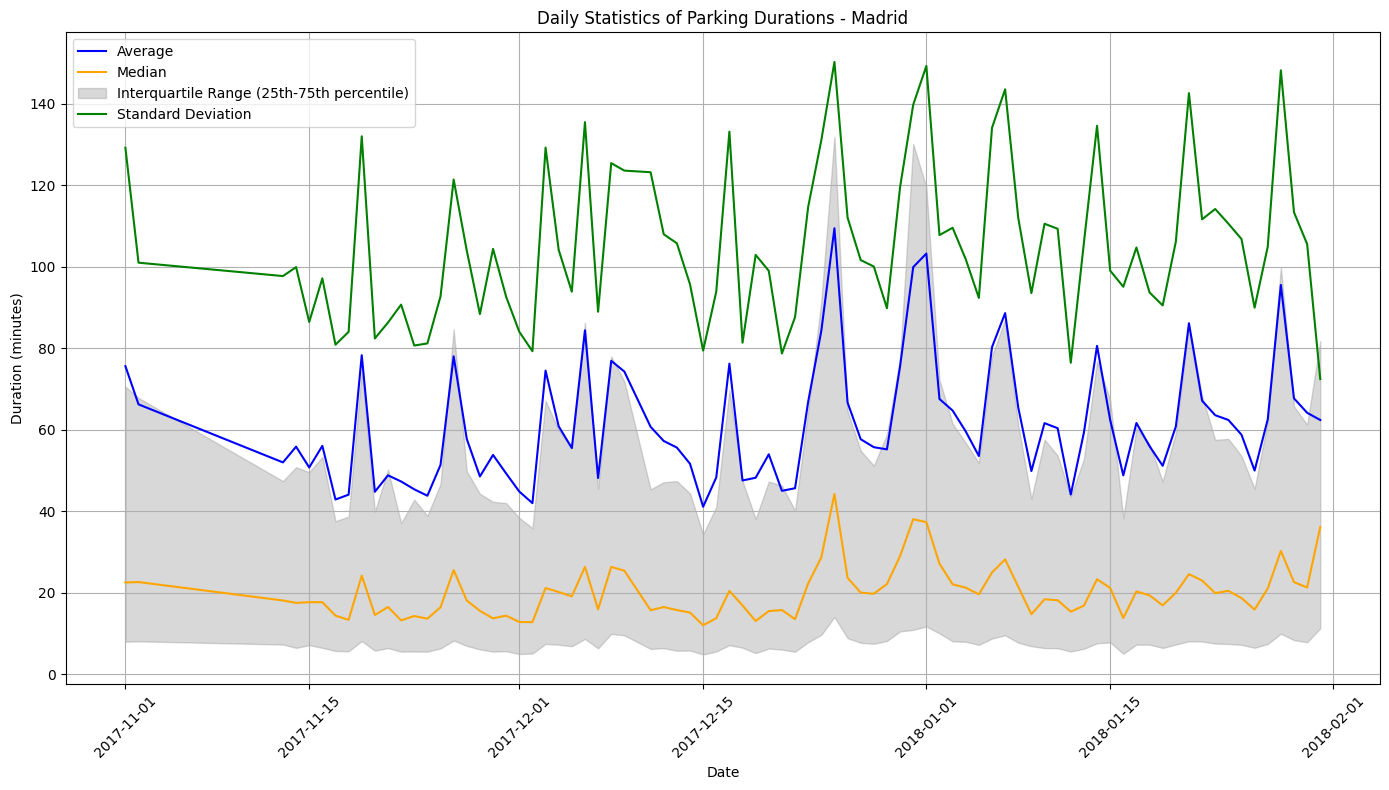

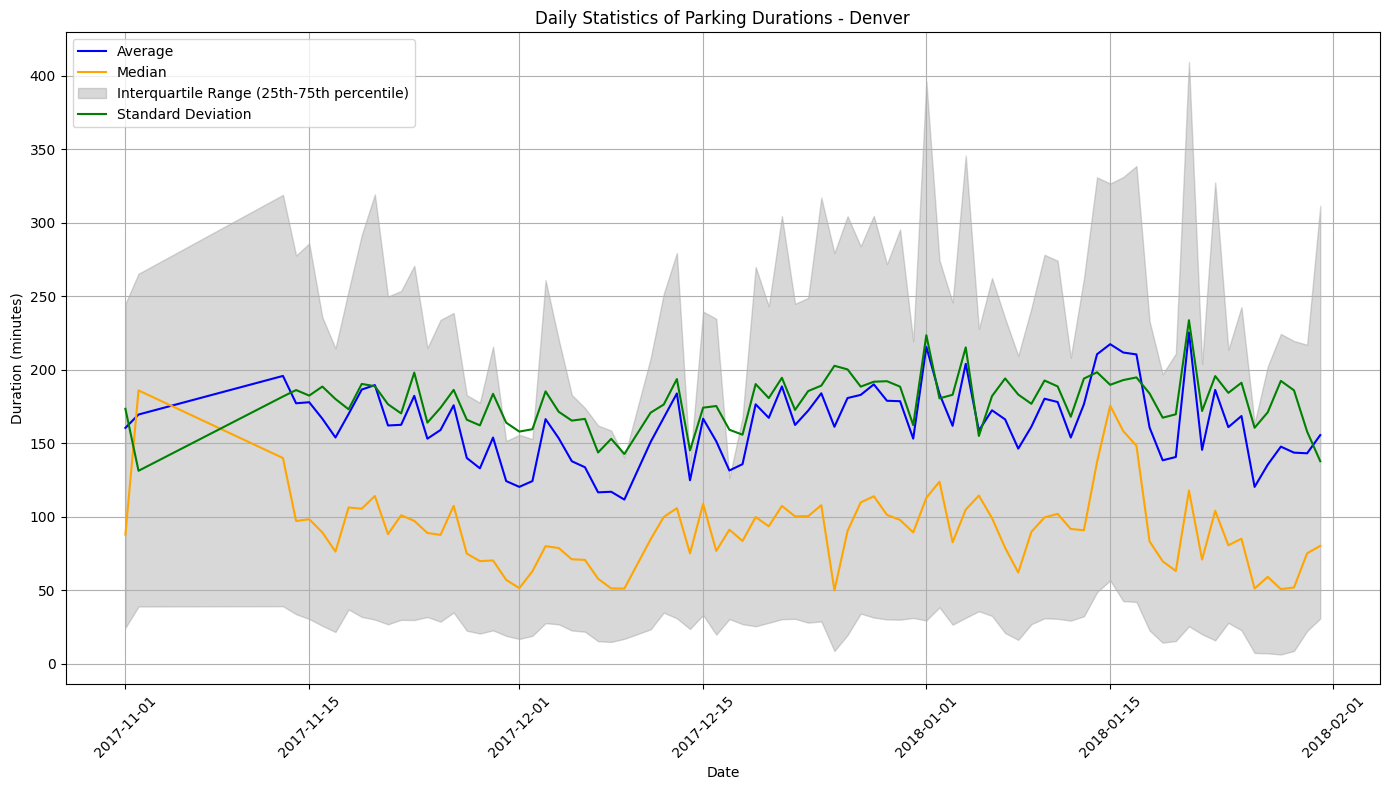

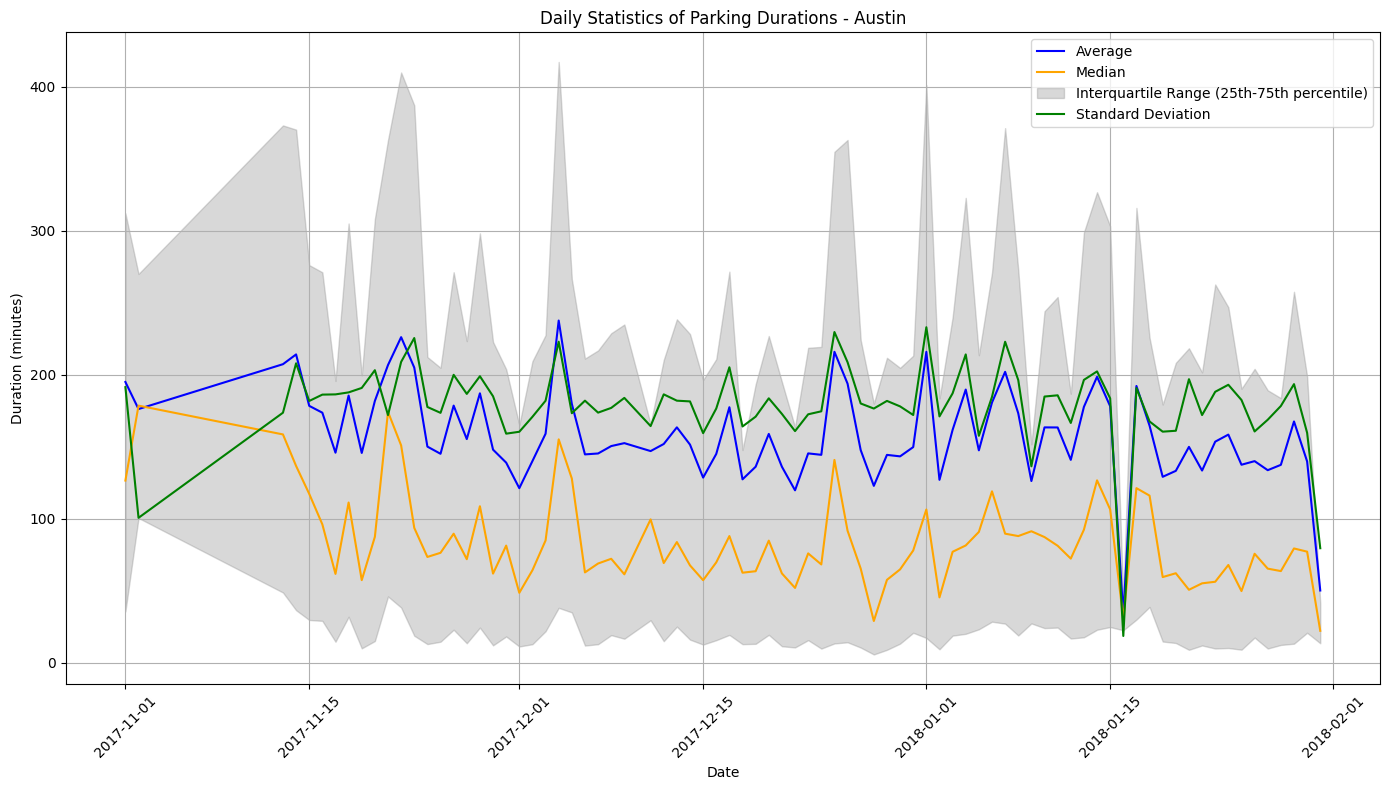

In [55]:
def get_filtered_durations(collection, city):
    pipeline = [
        {
            "$match": {
                "city": city,  # Filter by city
                "init_date": {"$gte": start_date, "$lt": end_date},  # Filter by date range
                "final_date": {"$exists": True}  # Ensure final_date exists
            }
        },
        {
            "$project": {
                "init_date": 1,
                "final_date": 1,
                "initial_position": 1,
                "final_position": 1,
                "duration": {
                    "$divide": [
                        {"$subtract": ["$final_date", "$init_date"]}, 1000 * 60  # Duration in minutes
                    ]
                }
            }
        },
        {
            "$match": {
                "duration": {"$gte": 2, "$lte": 720}  # Filter durations between 2 and 720 minutes
            }
        }
    ]

    # Run the aggregation pipeline
    results = list(collection.aggregate(pipeline))

    # Convert results to a pandas DataFrame
    df = pd.DataFrame(results)
    if not df.empty:
        df['init_date'] = pd.to_datetime(df['init_date'])
        df['final_date'] = pd.to_datetime(df['final_date'])
        # Post-process to filter bookings with distinct initial and final positions
        if 'initial_position' in df.columns and 'final_position' in df.columns:
            df = df[(df['initial_position'] != df['final_position']) | df['initial_position'].isna()]

    return df if not df.empty else pd.DataFrame()

# Dictionaries to store the durations
booking_durations = {}
parking_durations = {}

# Get filtered durations for each city
for city in cities:
    booking_durations[city] = get_filtered_durations(bookings_collection, city)
    parking_durations[city] = get_filtered_durations(parkings_collection, city)

# Function to compute daily statistics
def compute_daily_statistics(df):
    df['date'] = df['init_date'].dt.date  # Extract the date
    daily_stats = df.groupby('date')['duration'].agg(
        average='mean',
        median='median',
        std_dev='std',
        p25=lambda x: x.quantile(0.25),
        p50=lambda x: x.quantile(0.5),
        p75=lambda x: x.quantile(0.75)
    ).reset_index()
    return daily_stats

# Function to plot daily statistics for a single city
def plot_daily_statistics_for_city(daily_stats, city, title):
    plt.figure(figsize=(14, 8))

    plt.plot(daily_stats['date'], daily_stats['average'], label='Average', color='blue')
    plt.plot(daily_stats['date'], daily_stats['median'], label='Median', color='orange')
    plt.fill_between(daily_stats['date'], daily_stats['p25'], daily_stats['p75'], color='grey', alpha=0.3, label='Interquartile Range (25th-75th percentile)')
    plt.plot(daily_stats['date'], daily_stats['std_dev'], label='Standard Deviation', color='green')

    plt.xlabel('Date')
    plt.ylabel('Duration (minutes)')
    plt.title(f"{title} - {city}")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Compute and plot statistics for each city (bookings)
for city, df in booking_durations.items():
    if not df.empty:
        daily_stats = compute_daily_statistics(df)
        plot_daily_statistics_for_city(daily_stats, city, 'Daily Statistics of Booking Durations')

# Compute and plot statistics for each city (parkings)
for city, df in parking_durations.items():
    if not df.empty:
        daily_stats = compute_daily_statistics(df)
        plot_daily_statistics_for_city(daily_stats, city, 'Daily Statistics of Parking Durations')


### Question 6

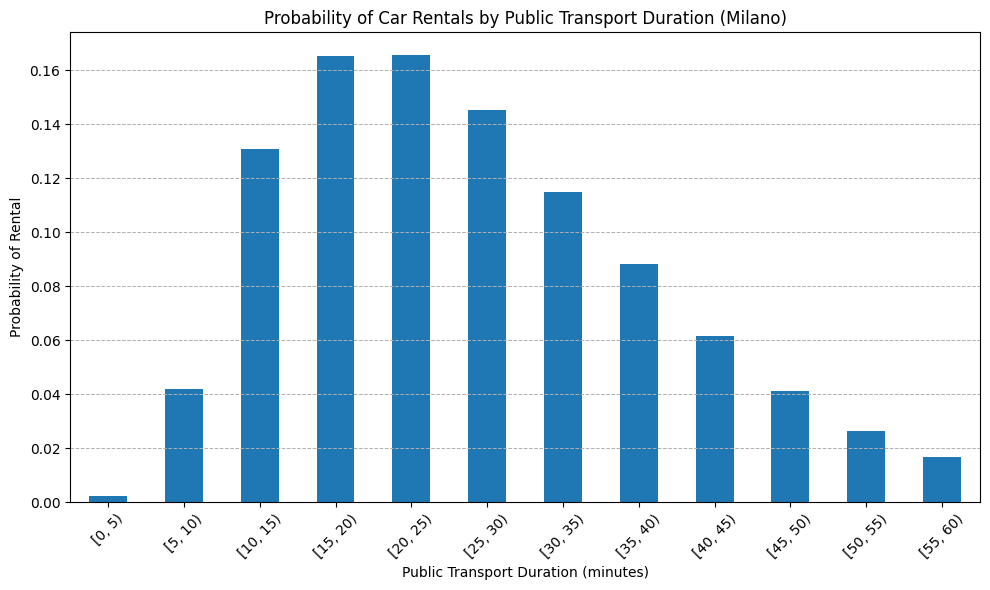

In [60]:
# Define bins for transport durations
bins = list(range(0, 65, 5))  # Bins: [0-5), [5-10), ..., [60-65)

def get_milan_rentals_with_transport():
    # Query to retrieve data for Milan with public transport information
    query = {
        "city": "Milano",
        "init_date": {"$gte": start_date, "$lte": end_date},
        "public_transport.duration": {"$exists": True}
    }
    projection = {
        '_id': 0,
        'init_date': 1,
        'public_transport': 1
    }
    data = list(bookings_collection.find(query, projection))
    df = pd.DataFrame(data)

    if not df.empty:
        df['init_date'] = pd.to_datetime(df['init_date'])
        df['transport_duration_minutes'] = df['public_transport'].apply(
            lambda x: x['duration'] / 60 if x and 'duration' in x and x['duration'] != -1 else None
        )
        df = df.dropna(subset=['transport_duration_minutes'])

    return df

def compute_rental_probabilities(df, bins):
    df['duration_bin'] = pd.cut(df['transport_duration_minutes'], bins=bins, right=False)
    rental_counts = df['duration_bin'].value_counts().sort_index()
    probabilities = rental_counts / rental_counts.sum()
    return probabilities

def plot_rental_probabilities(probabilities):
    plt.figure(figsize=(10, 6))
    probabilities.plot(kind='bar')
    plt.xlabel('Public Transport Duration (minutes)')
    plt.ylabel('Probability of Rental')
    plt.title('Probability of Car Rentals by Public Transport Duration (Milano)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', linewidth=0.7)
    plt.tight_layout()
    plt.show()

# Main logic
milan_rentals_df = get_milan_rentals_with_transport()
if not milan_rentals_df.empty:
    rental_probabilities = compute_rental_probabilities(milan_rentals_df, bins)
    plot_rental_probabilities(rental_probabilities)

### Question 7

A

In [71]:
def get_filtered_data_for_madrid():
    pipeline = [
        {
            "$match": {
                "city": "Madrid",
                "init_date": {"$gte": start_date, "$lte": end_date},
                "initial_position": {"$exists": True},
                "final_position": {"$exists": True}
            }
        },
        {
            "$project": {
                "init_date": 1,
                "initial_position": 1,
                "final_position": 1
            }
        }
    ]

    data = list(bookings_collection.aggregate(pipeline))
    print(f"Number of records retrieved: {len(data)}")  # Debug: Check if data is returned
    print(data[:5])  # Display a sample of the data for verification

    df = pd.DataFrame(data)

    if not df.empty:
        df['init_date'] = pd.to_datetime(df['init_date'])
        df['hour'] = df['init_date'].dt.hour
        df['weekday'] = df['init_date'].dt.weekday

    return df

# Main logic
city_data = get_filtered_data_for_madrid()
if city_data.empty:
    print("No data returned from MongoDB. Check your pipeline and query parameters.")
else:
    organized_data = prepare_dataframe(city_data)
    if organized_data.empty:
        print("No valid rows after filtering coordinates.")
    else:
        explore_with_geopandas(organized_data)


Number of records retrieved: 0
[]
No data returned from MongoDB. Check your pipeline and query parameters.
